# Biphenyl molecule simulation
We are looking for a solution for this variation of Shrodinger equation:
$$
\left[-\frac{\hbar^2}{2I}\frac{d^2}{d\phi^2} + V_0(\phi)\right] \psi_m(\phi) = E_m\psi_m(\phi)
$$
Where
$$
V_0(\phi)=\frac{1}{2}\left[V_2(1-\cos{2\phi}) + V_4(1-\cos{4\phi}) + V_6(1-\cos{6\phi})\right] + C
$$
_ref: Torsional potential of biphenyl: Ab initio calculations with the Dunning correlation consisted basis sets_  
And the boundary conditions are:
$$
\psi(0)=\psi(2\pi),
\psi'(0)=\psi'(2\pi)
$$

In [1]:
# Libraries for numerical calculations, linear algebra and visualizations
import numpy as np
from scipy.linalg import eigh_tridiagonal
from numpy import linalg as LA
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # for loading bars (to see progress visually during long integration)
from scipy import sparse

# For stylized plots
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80

In [2]:
# Potential energy constants
V_2 = 0.09 * 0.043361254529175 # Convert from kcal/mol to eV/particle
V_4 = -2.10 * 0.043361254529175 # Convert from kcal/mol to eV/particle
V_6 = -0.29 * 0.043361254529175 # Convert from kcal/mol to eV/particle
# SE constants
h_bar = 6.626070150 * 10**-34 # Plancks constant, kg*m^2/s
M = 1.9944733 * 10**-26 # Mass of carbon, kg
# d = 0.417 * 10**-9
# d = 3 * 10**-9
d = 1.5  * 10**-9 # Diameter of benzene ring (not sure about this one), m
I = 1/2 * M * d ** 2 # Moment of inertia
KE_C = h_bar**2 / (2 * I) # Kinetic energy operator's constant, J
KE_C = KE_C * 6.241509 * 10**18 # Convert from J to eV
print("Kinetic energy coefficient: ", KE_C)

# Square well potential, for testing purposes
a = 1
V_min = -46 # eV
# def potential(phi):
#     if phi < a and phi > -a:
#         return V_min / KE_C
#     else:
#         return 0

# Biphenyl rotation potential
def potential(phi):
    return 1/2 * (V_2 * (1 - np.cos(2 * phi))
                + V_4 * (1 - np.cos(4 * phi))
                + V_6 * (1 - np.cos(6 * phi))) / KE_C

potential = np.vectorize(potential)

Kinetic energy coefficient:  6.106479662795717e-05


In [3]:
# Define boundaries for eigenvalues of energies
from scipy.optimize import minimize
b_min = minimize(potential, 1).fun - 50 # Find minimum of the potential
b_max = 20

In [4]:
# We are looking for wave function solution in this range of phi:
# phi_1, phi_2 = -3, 3 # For square well
phi_1, phi_2 = 0, 2 * np.pi # For Biphenyl

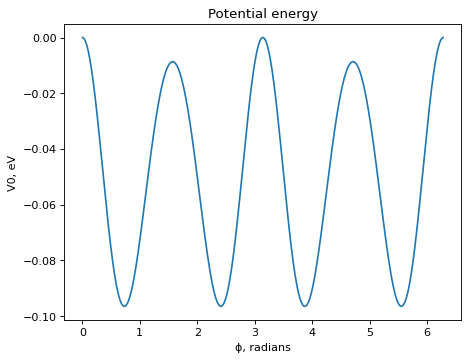

In [5]:
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
plt.title("Potential energy")
plt.xlabel(r'ϕ, radians')
plt.ylabel(r'V0, eV')
plt.show()

## Solution 2. Rewriting wave function in Fourier basis with sines and cosines
We rewrite our wave function in this form:
$$
\Psi(\phi)=\sum_{m=0}^{\infty} \left[ a_m\Phi_{mc}(\phi) + b_m\Phi_{ms}(\phi)\right],
$$
where
$$
\Phi_{ms}(\phi)=\frac{1}{\sqrt{\pi}}\sin{m\phi}$$ and  $$
\Phi_{mc}(\phi)=\frac{1}{\sqrt{\pi}}\cos{m\phi}.
$$
As an approximation, we use m from 0 to M, where M is large.  

In [6]:
# Define amount of cosines and sines for fourier basis
M = 72
n_trapz = 2000

H = np.zeros((M, M))

def basis_func(phi, m):
    # if m <= M/2:
    #     return np.cos(phi * m)
    # else:
    #     return np.sin(phi * m)
    if m % 2 == 0:
        return np.sin(phi * m)
    else:
        return np.cos(phi * m)

for m in tqdm(range(1, M+1)):
    for m_s in range(1, M+1):
        def integrand(phi):
            multiplier = 1 / np.pi * (m_s ** 2 * KE_C + potential(phi) * KE_C)
            multiplier *= basis_func(phi, m)
            multiplier *= basis_func(phi, m_s)
            return multiplier

        x = np.linspace(phi_1, phi_2, n_trapz)
        H[m - 1, m_s - 1] = np.trapz(integrand(x), dx = (phi_2 - phi_1) / n_trapz)

  0%|          | 0/72 [00:00<?, ?it/s]

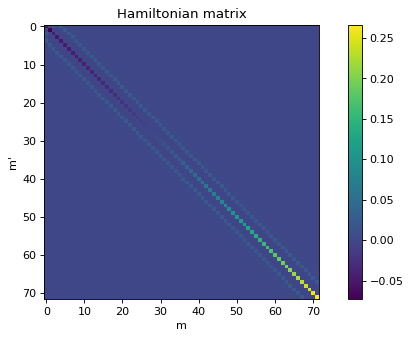

In [7]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
fig.tight_layout()

im1 = axes.imshow(H)
axes.set_title("Hamiltonian matrix")
axes.set_xlabel(r'm')
axes.set_ylabel(r"m'")
cbar = axes.figure.colorbar(im1, ax = axes, fraction=0.046, pad=0.04)

In [8]:
energies, wf_coefficients = LA.eig(H)

In [9]:
new_indexes = np.argsort(energies)
sorted_energies = energies[new_indexes]
sorted_wf_coefficients = wf_coefficients.T[new_indexes]
print(new_indexes[:5])

[20 22 25 26 31]


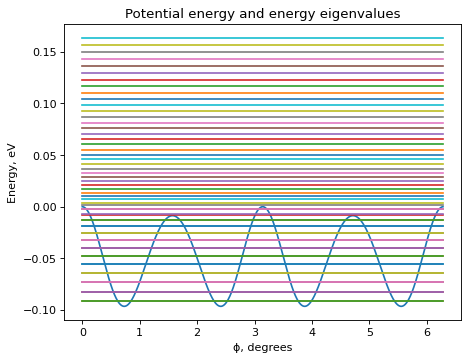

In [10]:
n_energies_to_plot = 60
x = np.arange(phi_1, phi_2, 0.01)
plt.plot(x, potential(x) * KE_C)
for i in range(0, min(n_energies_to_plot, len(sorted_energies)) - 1):
    plt.plot(x, np.ones(len(x)) * (sorted_energies[i]))
plt.title("Potential energy and energy eigenvalues")
plt.xlabel(r'ϕ, degrees')
plt.ylabel(r'Energy, eV')
plt.show()

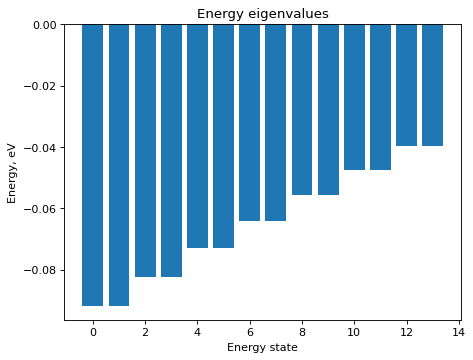

In [11]:
n_energies_to_plot = 15
plt.bar(np.arange(0, min(n_energies_to_plot, len(energies)) - 1, 1),
        sorted_energies[:min(n_energies_to_plot, len(energies)) - 1])
plt.title("Energy eigenvalues")
plt.xlabel(r'Energy state')
plt.ylabel(r'Energy, eV')
plt.show()

In [12]:
# Define wave function as sum
def psi(phi, C):
    res = 0
    for m, coef in enumerate(C):
        m = m + 1
        res += coef * basis_func(phi, m)
    return res

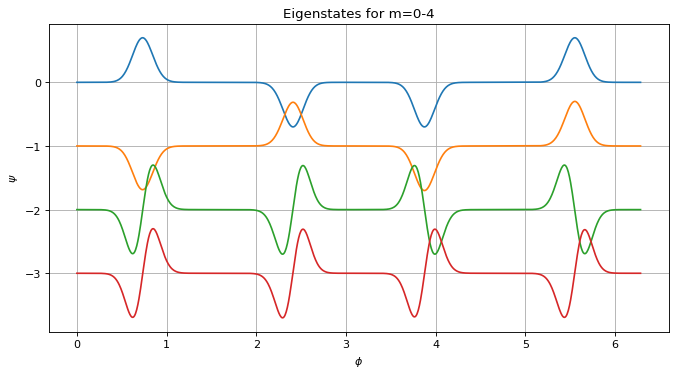

In [13]:
# Plot wave functions
N = 1000
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
for i in range(0, 4):
    plt.plot(phi, psi(phi, sorted_wf_coefficients[i]) /
             np.max(psi(phi, sorted_wf_coefficients[i])) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates for m=0-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()

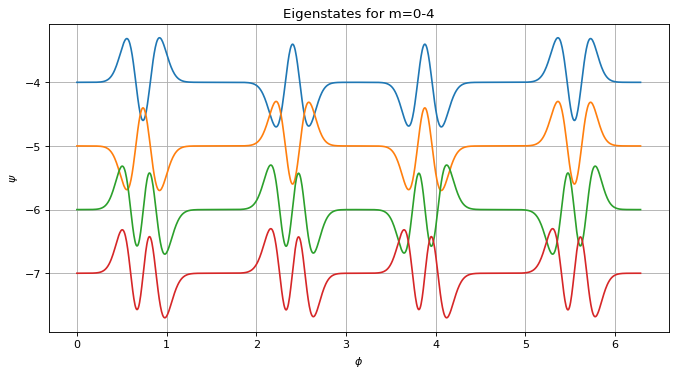

In [14]:
# Plot wave functions
N = 1000
phi = np.linspace(phi_1, phi_2, N)
plt.figure(figsize=(10,5))
for i in range(4, 8):
    plt.plot(phi, psi(phi, sorted_wf_coefficients[i]) /
             np.max(psi(phi, sorted_wf_coefficients[i])) * 0.7 - np.ones(N) * i)
plt.title('Eigenstates for m=0-4')
plt.ylabel('$\psi$')
plt.xlabel('$\phi$')
plt.grid()
plt.show()